In [ ]:
!pip install pandas
!pip install seaborn

In [1]:
import sys
sys.path.append('/workspace/yolov7')


In [12]:
import matplotlib.pyplot as plt
import torch
import cv2
from torchvision import transforms
import numpy as np
from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts
from utils.classification import plot_pose_skeleton,normalize_kpts

In [ ]:
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6-pose.pt

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weigths = torch.load('yolov7-w6-pose.pt', map_location=device)
model = weigths['model']
_ = model.float().eval()

if torch.cuda.is_available():
    model.half().to(device)

In [4]:
print(torch.cuda.is_available())

True


In [5]:
image = cv2.imread('/workspace/data/yoga82/download/Cobra_Pose_or_Bhujangasana_/2_62.jpg')
image = letterbox(image, 960, stride=64, auto=True)[0]
image_ = image.copy()
image = transforms.ToTensor()(image)
image = torch.tensor(np.array([image.numpy()]))

if torch.cuda.is_available():
    image = image.half().to(device)   
output, _ = model(image)
# print(output)


In [ ]:
# print(image)

In [6]:
!nvidia-smi

Sun May  7 20:04:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:09:00.0 Off |                  N/A |
| 27%   32C    P2    61W / 250W |   2474MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#image = cv2.imread('/workspace/yolov7/inference/images/workshop.jpg')
# print(image)

In [7]:
output = non_max_suppression_kpt(output, 0.25, 0.65, nc=model.yaml['nc'], nkpt=model.yaml['nkpt'], kpt_label=True)

with torch.no_grad():
    output = output_to_keypoint(output)
    #PErmutate image and scale RGB to a viewable scale
    nimg = image[0].permute(1, 2, 0) * 255
    #Move to numpy array on CPU
    nimg = nimg.cpu().numpy().astype(np.uint8)
    #Convert to BGR colour space for OpenCV
    nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
    
for idx in range(output.shape[0]):
#     print("plot_skeleton_ktps")
#     print(output[idx, 7:])
    plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)


In [ ]:
# print(output)
# temp_output = output[1,7:]
# len(temp_output)


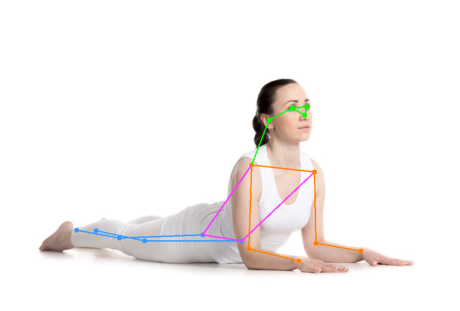

In [8]:
%matplotlib inline
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(nimg)
plt.show()

(525, 341) (420, 491)


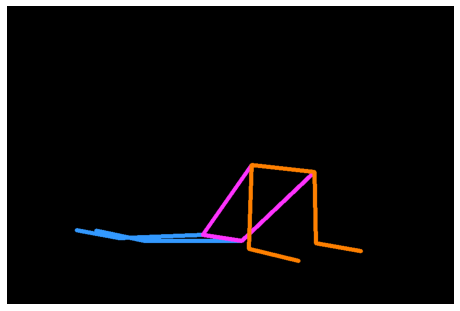

In [9]:
#create skeletons
for idx in range(output.shape[0]):
    skel_img = np.zeros((640,960,3), dtype = np.uint8);
    plot_pose_skeleton(skel_img, output[idx, 22:].T , 3)
    %matplotlib inline
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(skel_img)
    plt.show()

got here
341.5 547.0
(157, 1) (113, 186)


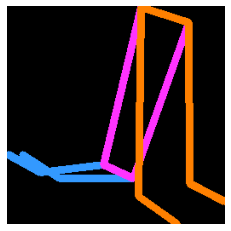

In [13]:
#create 256x256 skeletons, normalized
for idx in range(output.shape[0]):
    temp_kpts = output[idx,22:].T
    skel_img = np.zeros((256,256,3), dtype = np.uint8);
    normalize_kpts(temp_kpts, 3)
    plot_pose_skeleton(skel_img, temp_kpts , 3)
    %matplotlib inline
#     plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(skel_img)
    plt.show()

In [ ]:
output[idx, 22:].T

In [ ]:
len(output[idx, 7:].T)
output[idx, 22:].T

In [ ]:
test = np.array([        660,       356.5,     0.96973,       525.5,       341.5,      0.9834,       663.5,      509.25,     0.87158,       519.5,       521.5,     0.93311,       760.5,       526.5,       0.854,         626,         547,     0.88867,       504.5,      504.75,     0.85693,      420.75,       491.5,     0.87256,
            295.25,      504.75,     0.72754,      241.38,      498.75,      0.7334,         191,         482,     0.53223,      149.75,      481.75,     0.52197])
test
normalize_kpts(test,3)
test


In [ ]:
def normalize(x,x_min,x_max,interval=(0,1)):
    return interval[0] + (x-x_min)*(interval[1]-interval[0])/(x_max-x_min)
# normalize(50,0,100,(0,256))
#since skeleton function doesnt like 0 values we add a 1 pixel buffer around
def normalize_kpts(kpts, steps, interval=(1,255)):
    num_kpts = len(kpts) // steps
    #maybe hardcode indexes for this eventually for performance
    max1 = 0;
    max2 = 0;
    min1 = 1000;
    min2 = 1000;
    for n in range(num_kpts):
        if kpts[n*steps] > max1:
            max1 = kpts[n*steps]
        if kpts[n*steps] < min1:
            min1 = kpts[n*steps]
        if kpts[n*steps+1] > max2:
            max2 = kpts[n*steps+1]
        if kpts[n*steps+1] < min2:
            min2 = kpts[n*steps+1]
                   
    for n in range(num_kpts):
        kpts[n*steps] = normalize(kpts[n*steps],min1,max1,interval)
        if ( kpts[n*steps+1] == 341.5):
            print("got here")
            print(min2,max2)

        kpts[n*steps+1] = normalize(kpts[n*steps+1],min2,max2,interval)
        

In [ ]:
#adapted keypoint function for drawing a single pose skeleton per image
#scale using min-max feature scaling, remove head
def plot_pose_skeleton(im, kpts, steps, orig_shape=None):
    #Plot the skeleton and keypointsfor coco datatset
    palette = np.array([[255, 128, 0], [255, 153, 51], [255, 178, 102],
                        [230, 230, 0], [255, 153, 255], [153, 204, 255],
                        [255, 102, 255], [255, 51, 255], [102, 178, 255],
                        [51, 153, 255], [255, 153, 153], [255, 102, 102],
                        [255, 51, 51], [153, 255, 153], [102, 255, 102],
                        [51, 255, 51], [0, 255, 0], [0, 0, 255], [255, 0, 0],
                        [255, 255, 255]])

#     skeleton = [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13], [6, 12],
#                  [7, 13], [6, 7], [6, 8], [7, 9], [8, 10], [9, 11], [2, 3],
#                  [1, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7]]

    skeleton = [[11, 9], [9, 7], [12, 10], [10, 8], [7, 8], [1, 7],
                 [2, 8], [1, 2], [1, 3], [2, 4], [3, 5], [4, 6]] 

    pose_limb_color = palette[[9, 9, 9, 9, 7, 7, 7, 0, 0, 0, 0, 0]]
    
    num_kpts = len(kpts) // steps

    for sk_id, sk in enumerate(skeleton):
        
        r, g, b = pose_limb_color[sk_id]
        pos1 = (int(kpts[(sk[0]-1)*steps]), int(kpts[(sk[0]-1)*steps+1]))
        pos2 = (int(kpts[(sk[1]-1)*steps]), int(kpts[(sk[1]-1)*steps+1]))
        
        if steps == 3:
            conf1 = kpts[(sk[0]-1)*steps+2]
            conf2 = kpts[(sk[1]-1)*steps+2]
            if conf1<0.5 or conf2<0.5:
                continue
       
        if pos1[0]%960 == 0 or pos1[1]%960==0 or pos1[0]<0 or pos1[1]<0:
            continue
        if sk == [2, 8]:
            print(pos1,pos2)
        if pos2[0] % 960 == 0 or pos2[1] % 960 == 0 or pos2[0]<0 or pos2[1]<0:
            continue
       
        cv2.line(im, pos1, pos2, (int(r), int(g), int(b)), thickness=7)